In [66]:
#Creator Jay Dangi.

import pandas as pd
import rdflib
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD
from rdflib import URIRef, Namespace, Literal, BNode
import re
import datetime
from time import strptime
from datetime import date
import stardog
import io
import seaborn as sns
from matplotlib import pyplot as plt

In [23]:
loan_data = pd.read_csv('C:/Users/Jay/Downloads/LoanStatus/Loan payments data.csv')
loan_data.head()


,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


In [24]:
type('age')

str

In [31]:
SCHEMA = Namespace("http://schema.org/")
EX = Namespace("http://example.com/")


In [55]:
g = rdflib.Graph()
for index,row in loan_data.iterrows():
    loan_id = URIRef(SCHEMA + row[0])
    g.add((loan_id, RDF.type, SCHEMA.leiCode))
    
    
    person_info = BNode()
    if(len(str(row['age']))>0):
        g.add((person_info, SCHEMA.requiredMinAge , Literal(row['age'],datatype = XSD.integer)))
    if(len(row['Gender'])>0):
        g.add((person_info, SCHEMA.gender, Literal(row['Gender'])))
    if(len(row['education'])>0):
        education = URIRef(EX + re.sub('\\W+','', row['education']))
        g.add((person_info, SCHEMA.educationalCredentialAwarded, education))
    g.add((loan_id, SCHEMA.ContactPoint, person_info))
    g.add((person_info, RDF.type, SCHEMA.Person))
    
    
    if(len(row['loan_status'])>0):
        g.add((loan_id, SCHEMA.PayAction, Literal(row['loan_status'])))
        
    if(len(str(row['Principal']))>0):
        g.add((loan_id, SCHEMA.amount, Literal(row['Principal'],datatype=XSD.integer)))
        
    if(len(str(row['terms']))>0):
        g.add((loan_id, SCHEMA.numberOfLoanPayments, Literal(row['terms'],datatype=XSD.integer)))
        
    if(len(str(row['paid_off_time']))>0):
        g.add((loan_id, SCHEMA.endTIme, Literal(row['paid_off_time'],datatype=XSD.DateTime)))
        
    if(len(str(row['due_date']))>0):
        g.add((loan_id, SCHEMA.paymentDueDate, Literal(row['due_date'],datatype=XSD.Date)))
        
    if(len(str(row['effective_date']))>0):
        g.add((loan_id, SCHEMA.Date, Literal(row['effective_date'],datatype=XSD.Date)))
        
    if(len(str(row['past_due_days']))>0 or str(row['past_due_days']=='NaN')):
        g.add((loan_id, SCHEMA.gracePeriod, Literal(row['Principal'],datatype=XSD.Duration)))
        
        

In [57]:
g.serialize(destination="C:/Users/Jay/Downloads/Loan_Graph.ttl",format="turtle")

In [59]:
conn_details = {
  'endpoint': 'http://localhost:5820',
  'username': 'admin',
  'password': 'admin'
}

with stardog.Admin(**conn_details) as admin:
    loanStatus = admin.new_database('loanStatus')

with stardog.Connection('loanStatus', **conn_details) as conn:
    conn.begin()
    conn.add(stardog.content.File("C:/Users/Jay/Downloads/Loan_Graph.ttl"))
    conn.commit()
    

StardogException: [400] 0D0DE2: Database already exists: loanStatus

In [62]:
conn.size()

6500

In [98]:
query1="""
PREFIX ex:<http://example.com/>
PREFIX schema:<http://schema.org/>
SELECT ?gender (COUNT(?principal) AS ?Total)
{{
    ?loanid a schema:LoanOrCredit;
            schema:ContactPoint ?Personinfo;
            schema:amount ?principal.
    ?Personinfo a schema:Person;
                schema:gender ?gender.
    FILTER(?principal = {})
  
}}
GROUP BY ?gender
"""
results=conn.select(query1.format(1000),content_type='text/csv')
df=pd.read_csv(io.BytesIO(results))
df.head()

,gender,Total
0,female,57
1,male,320


In [93]:
query2="""
PREFIX ex:<http://example.com/>
PREFIX schema:<http://schema.org/>
SELECT  ?age ?terms
{
    ?loanid a schema:LoanOrCredit;
            schema:ContactPoint ?Personinfo;
            schema:numberOfLoanPayments ?terms.
    ?Personinfo a schema:Person;
                schema:gender ?gender;
                schema:requiredMinAge ?age.
  
            
}
"""
results=conn.select(query2,content_type='text/csv')
df2=pd.read_csv(io.BytesIO(results))
df2.head()

,age,terms
0,28,15
1,28,30
2,35,15
3,30,15
4,33,30


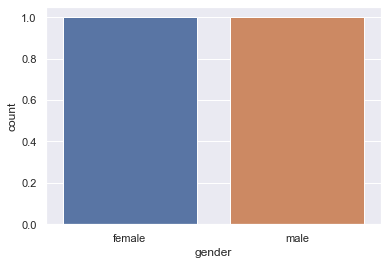

In [99]:
sns.set(style='darkgrid')
sns.countplot(x='gender', data = df)

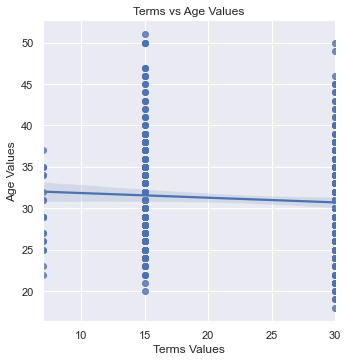

In [96]:
sns.lmplot(x='terms',y='age',data=df2)
plt.xlabel('Terms Values')
plt.ylabel('Age Values')
plt.title('Terms vs Age Values')
plt.show()

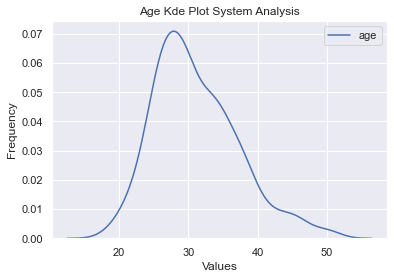

In [101]:
sns.kdeplot(df2['age'])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Age Kde Plot System Analysis')
plt.show()

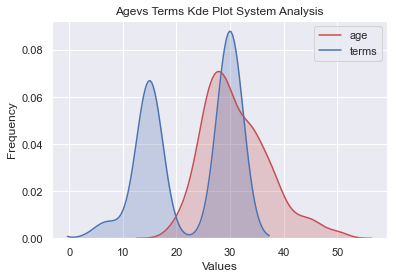

In [102]:
sns.kdeplot(df2['age'],shade=True,color='r')
sns.kdeplot(df2['terms'],shade=True,color='b')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Agevs Terms Kde Plot System Analysis')
plt.show()

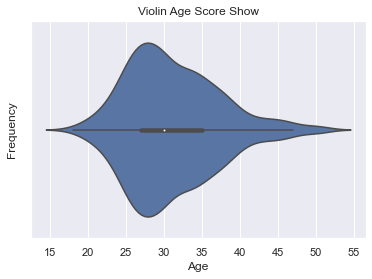

In [103]:
sns.violinplot(df2['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Violin Age Score Show')
plt.show()

In [104]:
query3='''
PREFIX ex:<http://example.com/>
PREFIX schema:<http://schema.org/>
SELECT  ?gender ?education
{
    ?loanid a schema:LoanOrCredit;
            schema:ContactPoint ?Personinfo;
            schema:numberOfLoanPayments ?terms.
    ?Personinfo a schema:Person;
                schema:gender ?gender;
                schema:educationalCredentialAwarded ?edu.
    bind(REPLACE(STR(?edu),"http://example.com/","") AS ?education)
  
            
}
'''
results=conn.select(query3,content_type='text/csv')
data=pd.read_csv(io.BytesIO(results))
data.head()

,gender,education
0,female,college
1,male,HighSchoolorBelow
2,male,HighSchoolorBelow
3,male,college
4,female,Bechalor


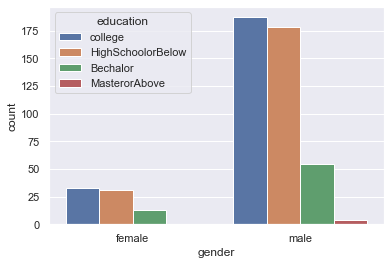

In [105]:
sns.countplot(data['gender'],hue=data['education'])
plt.show()

In [106]:
query4='''PREFIX ex:<http://example.com/>
PREFIX schema:<http://schema.org/>
SELECT  ?gender ?age
{
    ?loanid a schema:LoanOrCredit;
            schema:ContactPoint ?Personinfo;
            schema:numberOfLoanPayments ?terms.
    ?Personinfo a schema:Person;
                schema:gender ?gender;
                schema:requiredMinAge ?age.
}
'''
results=conn.select(query4,content_type='text/csv')
data2=pd.read_csv(io.BytesIO(results))
data2.head()

,gender,age
0,female,28
1,male,28
2,male,35
3,male,30
4,female,33


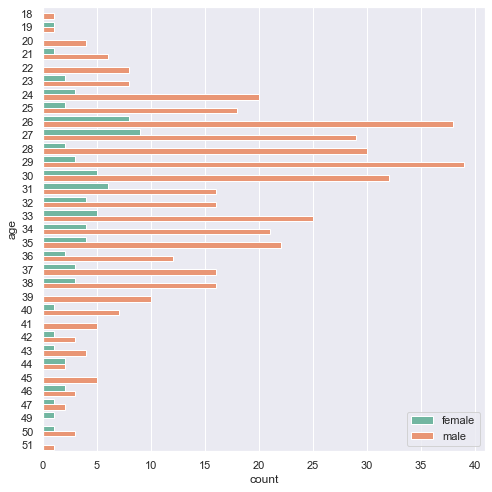

In [107]:
plt.figure(figsize=(7,7))
sns.countplot(y=data2['age'],palette="Set2",hue=data2['gender'])
plt.legend(loc=4)
plt.tight_layout()
plt.show()